In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

import emmental
from emmental import Meta
from emmental.data import EmmentalDataLoader, EmmentalDataset
from emmental.learner import EmmentalLearner
from emmental.model import EmmentalModel
from emmental.scorer import Scorer
from emmental.task import EmmentalTask

In [3]:
emmental.init("test_run")

[2019-04-21 16:48:05,111][INFO] emmental.meta:95 - Setting logging directory to: test_run/2019_04_21/16_48_05
[2019-04-21 16:48:05,122][INFO] emmental.meta:56 - Loading Emmental default config from /Users/senwu/Desktop/folder/deleteme/test/test/test/emmental/src/emmental/emmental-default-config.yaml.


### Generate data

In [4]:
N = 200
X = np.random.random((N, 2)) * 2 - 1
Y = (X[:, 0] > X[:, 1] + 0.25).astype(int) + 1

In [5]:
# categorical labels: 
Y1_mask = Y == 1
Y2_mask = Y == 2

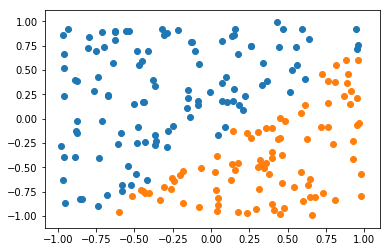

In [6]:
plt.scatter(X[Y1_mask, 0], X[Y1_mask, 1])
plt.scatter(X[Y2_mask, 0], X[Y2_mask, 1])
plt.show()

### Load config

In [7]:
Meta.config

{'meta_config': {'seed': 0, 'verbose': True, 'device': 0},
 'learner_config': {'fp16': False,
  'model_path': None,
  'seed': None,
  'verbose': True,
  'progress_bar': True,
  'n_epochs': 1,
  'train_split': 'train',
  'valid_split': 'valid',
  'test_split': 'test',
  'optimizer_config': {'optimizer': 'sgd',
   'lr': 0.001,
   'l2': 0.0,
   'grad_clip': 1.0,
   'sgd_config': {'momentum': 0.9},
   'adam_config': {'betas': (0.9, 0.999)}},
  'lr_scheduler_config': {'lr_scheduler': None,
   'warmup_steps': 0.0,
   'warmup_unit': 'epoch',
   'min_lr': 0.0,
   'linear_config': {'min_lr': 0.0},
   'exponential_config': {'gamma': 0.9},
   'plateau_config': {'factor': 0.5, 'patience': 10, 'threshold': 0.0001}},
  'task_scheduler': 'round_robin'},
 'logging_config': {'counter_unit': 'batch',
  'evaluation_freq': 2,
  'writer_config': {'writer': 'tensorboard', 'verbose': True},
  'checkpointint': True,
  'checkpointer_config': {'checkpoint_path': None,
   'checkpoint_freq': 1,
   'checkpoint_met

### Create tasks

In [8]:
def mse_loss(immediate_ouput, Y):
    mse = nn.MSELoss()
    return mse(immediate_ouput[-1][0].view(-1), Y.view(-1))

In [9]:
def ce_loss(immediate_ouput, Y):
#     F.cross_entropy(X["data"], Y.view(-1) - 1))
#     ce = nn.BCELoss()
#     print(immediate_ouput[-1][0].size(), Y.size())
    return F.cross_entropy(immediate_ouput[-1][0], Y.view(-1) - 1)

In [10]:
def output(immediate_ouput):
    return immediate_ouput[-1][0]

In [11]:
task1 = EmmentalTask(
    name="task1",
    module_pool=nn.ModuleDict(
        {
            "input_module": nn.Linear(2, 8),
            "middle_module": nn.Linear(8, 8),
            "head_module1": nn.Linear(8, 2),
        }
    ),
    task_flow=[
        {"module": "input_module", "inputs": [(0, 'data')]},
        {"module": "middle_module", "inputs": [(1, 0)]},
        {"module": "head_module1", "inputs": [(2, 0)]},
    ],
    loss_func=ce_loss,
    output_func=output,
    scorer=Scorer(metrics=['f1', 'accuracy']),
)

[2019-04-21 16:48:05,528][INFO] emmental.task:34 - Created task: task1


In [12]:
task2 = EmmentalTask(
    name="task2",
    module_pool=nn.ModuleDict(
        {
            "input_module": nn.Linear(2, 8),
            "middle_module": nn.Linear(8, 8),
            "head_module2": nn.Linear(8, 2),
        }
    ),
    task_flow=[
        {"module": "input_module", "inputs": [(0, 'data')]},
        {"module": "middle_module", "inputs": [(1, 0)]},
        {"module": "head_module2", "inputs": [(2, 0)]},
    ],
    loss_func=ce_loss,
    output_func=output,
    scorer=Scorer(metrics=['f1', 'accuracy']),
)

[2019-04-21 16:48:05,559][INFO] emmental.task:34 - Created task: task2


In [13]:
mtl_model = EmmentalModel(name = 'all', tasks=[task1, task2])

[2019-04-21 16:48:05,584][INFO] emmental.model:61 - No cuda device available. Switch to cpu instead.
[2019-04-21 16:48:05,585][INFO] emmental.model:61 - No cuda device available. Switch to cpu instead.
[2019-04-21 16:48:05,586][INFO] emmental.model:44 - Created emmental model all that contains task {'task2', 'task1'}.
[2019-04-21 16:48:05,586][INFO] emmental.model:61 - No cuda device available. Switch to cpu instead.


In [14]:
import torch
torch.cuda.is_available()

False

In [15]:
# mtl_model1 = EmmentalModel(name = 'all', tasks=[task1, task1])

### Generate dataloader

In [16]:
splits = [0.8, 0.1, 0.1]

X_train, X_dev, X_test = [], [], []
Y_train, Y_dev, Y_test = [], [], []

for i in range(N):
    if i <= N * splits[0]:
        X_train.append(torch.Tensor(X[i]))
        Y_train.append(torch.Tensor([Y[i]]).type(torch.LongTensor))
    elif i < N * (splits[0] + splits[1]):
        X_dev.append(torch.Tensor(X[i]))
        Y_dev.append(torch.Tensor([Y[i]]).type(torch.LongTensor))
    else:
        X_test.append(torch.Tensor(X[i]))
        Y_test.append(torch.Tensor([Y[i]]).type(torch.LongTensor))

In [17]:
train_dataset = EmmentalDataset(name="da1", X_dict={"data": X_train}, Y_dict={"label": Y_train})
dev_dataset = EmmentalDataset(name="da1", X_dict= {"data": X_dev}, Y_dict={"label": Y_dev})
test_dataset = EmmentalDataset(name="da1", X_dict= {"data": X_test}, Y_dict={"label": Y_test})

In [18]:
train_dataloader1 = EmmentalDataLoader(
    task_name="task1", dataset=train_dataset, label_name="label", split="train", batch_size=10
)
dev_dataloader1 = EmmentalDataLoader(
    task_name="task1", dataset=dev_dataset, label_name="label", split="valid", batch_size=10
)
test_dataloader1 = EmmentalDataLoader(
    task_name="task1", dataset=test_dataset, label_name="label", split="test", batch_size=10
)

In [19]:
train_dataloader2 = EmmentalDataLoader(
    task_name="task2", dataset=train_dataset, label_name="label", split="train", batch_size=20
)
dev_dataloader2 = EmmentalDataLoader(
    task_name="task2", dataset=dev_dataset, label_name="label", split="valid", batch_size=10
)
test_dataloader2 = EmmentalDataLoader(
    task_name="task2", dataset=test_dataset, label_name="label", split="test", batch_size=10
)

In [20]:
emmental_learner = EmmentalLearner()

In [21]:
Meta.update_config(config = {"learner_config": {"n_epochs": 10, "optimizer_config": {"lr": 0.01}}})

[2019-04-21 16:48:05,804][INFO] emmental.meta:143 - Updating Emmental config from user provided config.


In [22]:
emmental_learner.learn(mtl_model, [train_dataloader1, train_dataloader2, dev_dataloader1, dev_dataloader2])

[2019-04-21 16:48:05,833][INFO] emmental.utils.logging.logging_manager:33 - Evaluating every 2 batch.
[2019-04-21 16:48:05,833][INFO] emmental.utils.logging.logging_manager:40 - Checkpointing every 2 batch.
[2019-04-21 16:48:05,846][INFO] emmental.utils.logging.checkpointer:41 - Save checkpoints at test_run/2019_04_21/16_48_05 every 2 batch
[2019-04-21 16:48:05,847][INFO] emmental.utils.logging.checkpointer:65 - No checkpoints saved before 0 batch.
[2019-04-21 16:48:05,848][INFO] emmental.learner:247 - Start learning...


[2019-04-21 16:48:05,889][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 2 batch at test_run/2019_04_21/16_48_05/checkpoint_2.pth.
[2019-04-21 16:48:05,891][INFO] emmental.utils.logging.checkpointer:101 - Save best model of metric task1/da1/valid/f1 at test_run/2019_04_21/16_48_05/best_model_task1_da1_valid_f1.pth
[2019-04-21 16:48:05,908][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 4 batch at test_run/2019_04_21/16_48_05/checkpoint_4.pth.
[2019-04-21 16:48:05,910][INFO] emmental.utils.logging.checkpointer:101 - Save best model of metric task1/da1/valid/f1 at test_run/2019_04_21/16_48_05/best_model_task1_da1_valid_f1.pth
[2019-04-21 16:48:05,926][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 6 batch at test_run/2019_04_21/16_48_05/checkpoint_6.pth.
[2019-04-21 16:48:05,928][INFO] emmental.utils.logging.checkpointer:101 - Save best model of metric task1/da1/valid/f1 at test_run/2019_04_21/16_48_05/best_model_task1_da1_valid_f1

task1
task2
task1
task2
task1
task2
task1
task2
task1
task2
task1
task2
task1
task2
task1
task2
task1
task2
task1
task1
task1
task1
task1
task1


[2019-04-21 16:48:06,082][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 24 batch at test_run/2019_04_21/16_48_05/checkpoint_24.pth.
[2019-04-21 16:48:06,084][INFO] emmental.utils.logging.checkpointer:101 - Save best model of metric task1/da1/valid/f1 at test_run/2019_04_21/16_48_05/best_model_task1_da1_valid_f1.pth
[2019-04-21 16:48:06,101][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 26 batch at test_run/2019_04_21/16_48_05/checkpoint_26.pth.
[2019-04-21 16:48:06,102][INFO] emmental.utils.logging.checkpointer:101 - Save best model of metric task1/da1/valid/f1 at test_run/2019_04_21/16_48_05/best_model_task1_da1_valid_f1.pth


task1
task1



[2019-04-21 16:48:06,141][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 28 batch at test_run/2019_04_21/16_48_05/checkpoint_28.pth.
[2019-04-21 16:48:06,165][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 30 batch at test_run/2019_04_21/16_48_05/checkpoint_30.pth.
[2019-04-21 16:48:06,181][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 32 batch at test_run/2019_04_21/16_48_05/checkpoint_32.pth.
[2019-04-21 16:48:06,182][INFO] emmental.utils.logging.checkpointer:101 - Save best model of metric task1/da1/valid/f1 at test_run/2019_04_21/16_48_05/best_model_task1_da1_valid_f1.pth
[2019-04-21 16:48:06,199][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 34 batch at test_run/2019_04_21/16_48_05/checkpoint_34.pth.
[2019-04-21 16:48:06,217][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 36 batch at test_run/2019_04_21/16_48_05/checkpoint_36.pth.
[2019-04-21 16:48:06,235][INFO] emmental.utils.logging.

task1
task2
task1
task2
task1
task2
task1
task2
task1
task2
task1
task2
task1
task2
task1
task2
task1
task2


[2019-04-21 16:48:06,303][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 46 batch at test_run/2019_04_21/16_48_05/checkpoint_46.pth.
[2019-04-21 16:48:06,320][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 48 batch at test_run/2019_04_21/16_48_05/checkpoint_48.pth.


task1
task1
task1
task1
task1
task1


[2019-04-21 16:48:06,340][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 50 batch at test_run/2019_04_21/16_48_05/checkpoint_50.pth.
[2019-04-21 16:48:06,356][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 52 batch at test_run/2019_04_21/16_48_05/checkpoint_52.pth.


task1
task1



[2019-04-21 16:48:06,394][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 54 batch at test_run/2019_04_21/16_48_05/checkpoint_54.pth.
[2019-04-21 16:48:06,413][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 56 batch at test_run/2019_04_21/16_48_05/checkpoint_56.pth.
[2019-04-21 16:48:06,429][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 58 batch at test_run/2019_04_21/16_48_05/checkpoint_58.pth.
[2019-04-21 16:48:06,431][INFO] emmental.utils.logging.checkpointer:101 - Save best model of metric task1/da1/valid/f1 at test_run/2019_04_21/16_48_05/best_model_task1_da1_valid_f1.pth
[2019-04-21 16:48:06,447][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 60 batch at test_run/2019_04_21/16_48_05/checkpoint_60.pth.
[2019-04-21 16:48:06,463][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 62 batch at test_run/2019_04_21/16_48_05/checkpoint_62.pth.
[2019-04-21 16:48:06,482][INFO] emmental.utils.logging.

task1
task2
task1
task2
task1
task2
task1
task2
task1
task2
task1
task2
task1
task2


[2019-04-21 16:48:06,500][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 66 batch at test_run/2019_04_21/16_48_05/checkpoint_66.pth.
[2019-04-21 16:48:06,517][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 68 batch at test_run/2019_04_21/16_48_05/checkpoint_68.pth.
[2019-04-21 16:48:06,533][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 70 batch at test_run/2019_04_21/16_48_05/checkpoint_70.pth.


task1
task2
task1
task2
task1
task1


[2019-04-21 16:48:06,551][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 72 batch at test_run/2019_04_21/16_48_05/checkpoint_72.pth.
[2019-04-21 16:48:06,570][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 74 batch at test_run/2019_04_21/16_48_05/checkpoint_74.pth.


task1
task1
task1
task1


[2019-04-21 16:48:06,589][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 76 batch at test_run/2019_04_21/16_48_05/checkpoint_76.pth.
[2019-04-21 16:48:06,606][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 78 batch at test_run/2019_04_21/16_48_05/checkpoint_78.pth.


task1
task1



[2019-04-21 16:48:06,647][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 80 batch at test_run/2019_04_21/16_48_05/checkpoint_80.pth.
[2019-04-21 16:48:06,665][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 82 batch at test_run/2019_04_21/16_48_05/checkpoint_82.pth.
[2019-04-21 16:48:06,682][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 84 batch at test_run/2019_04_21/16_48_05/checkpoint_84.pth.
[2019-04-21 16:48:06,699][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 86 batch at test_run/2019_04_21/16_48_05/checkpoint_86.pth.


task1
task2
task1
task2
task1
task2
task1
task2
task1


[2019-04-21 16:48:06,716][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 88 batch at test_run/2019_04_21/16_48_05/checkpoint_88.pth.
[2019-04-21 16:48:06,736][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 90 batch at test_run/2019_04_21/16_48_05/checkpoint_90.pth.
[2019-04-21 16:48:06,754][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 92 batch at test_run/2019_04_21/16_48_05/checkpoint_92.pth.


task2
task1
task2
task1
task2


[2019-04-21 16:48:06,773][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 94 batch at test_run/2019_04_21/16_48_05/checkpoint_94.pth.
[2019-04-21 16:48:06,791][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 96 batch at test_run/2019_04_21/16_48_05/checkpoint_96.pth.


task1
task2
task1
task2


[2019-04-21 16:48:06,811][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 98 batch at test_run/2019_04_21/16_48_05/checkpoint_98.pth.
[2019-04-21 16:48:06,830][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 100 batch at test_run/2019_04_21/16_48_05/checkpoint_100.pth.


task1
task1
task1
task1


[2019-04-21 16:48:06,851][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 102 batch at test_run/2019_04_21/16_48_05/checkpoint_102.pth.
[2019-04-21 16:48:06,868][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 104 batch at test_run/2019_04_21/16_48_05/checkpoint_104.pth.


task1
task1
task1
task1



task1
task2


[2019-04-21 16:48:06,909][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 106 batch at test_run/2019_04_21/16_48_05/checkpoint_106.pth.
[2019-04-21 16:48:06,927][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 108 batch at test_run/2019_04_21/16_48_05/checkpoint_108.pth.
[2019-04-21 16:48:06,945][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 110 batch at test_run/2019_04_21/16_48_05/checkpoint_110.pth.


task1
task2
task1
task2
task1
task2


[2019-04-21 16:48:06,964][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 112 batch at test_run/2019_04_21/16_48_05/checkpoint_112.pth.
[2019-04-21 16:48:06,984][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 114 batch at test_run/2019_04_21/16_48_05/checkpoint_114.pth.


task1
task2
task1
task2


[2019-04-21 16:48:07,006][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 116 batch at test_run/2019_04_21/16_48_05/checkpoint_116.pth.
[2019-04-21 16:48:07,025][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 118 batch at test_run/2019_04_21/16_48_05/checkpoint_118.pth.


task1
task2
task1
task2


[2019-04-21 16:48:07,044][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 120 batch at test_run/2019_04_21/16_48_05/checkpoint_120.pth.
[2019-04-21 16:48:07,063][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 122 batch at test_run/2019_04_21/16_48_05/checkpoint_122.pth.
[2019-04-21 16:48:07,080][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 124 batch at test_run/2019_04_21/16_48_05/checkpoint_124.pth.


task1
task2
task1
task1
task1
task1


[2019-04-21 16:48:07,099][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 126 batch at test_run/2019_04_21/16_48_05/checkpoint_126.pth.


task1
task1


[2019-04-21 16:48:07,117][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 128 batch at test_run/2019_04_21/16_48_05/checkpoint_128.pth.
[2019-04-21 16:48:07,135][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 130 batch at test_run/2019_04_21/16_48_05/checkpoint_130.pth.


task1
task1



task1
task2


[2019-04-21 16:48:07,178][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 132 batch at test_run/2019_04_21/16_48_05/checkpoint_132.pth.
[2019-04-21 16:48:07,195][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 134 batch at test_run/2019_04_21/16_48_05/checkpoint_134.pth.


task1
task2
task1
task2


[2019-04-21 16:48:07,213][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 136 batch at test_run/2019_04_21/16_48_05/checkpoint_136.pth.
[2019-04-21 16:48:07,231][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 138 batch at test_run/2019_04_21/16_48_05/checkpoint_138.pth.
[2019-04-21 16:48:07,248][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 140 batch at test_run/2019_04_21/16_48_05/checkpoint_140.pth.


task1
task2
task1
task2


[2019-04-21 16:48:07,267][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 142 batch at test_run/2019_04_21/16_48_05/checkpoint_142.pth.
[2019-04-21 16:48:07,283][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 144 batch at test_run/2019_04_21/16_48_05/checkpoint_144.pth.
[2019-04-21 16:48:07,300][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 146 batch at test_run/2019_04_21/16_48_05/checkpoint_146.pth.


task1
task2
task1
task2
task1
task2
task1


[2019-04-21 16:48:07,317][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 148 batch at test_run/2019_04_21/16_48_05/checkpoint_148.pth.


task2
task1


[2019-04-21 16:48:07,335][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 150 batch at test_run/2019_04_21/16_48_05/checkpoint_150.pth.
[2019-04-21 16:48:07,351][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 152 batch at test_run/2019_04_21/16_48_05/checkpoint_152.pth.


task1
task1
task1
task1
task1


[2019-04-21 16:48:07,370][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 154 batch at test_run/2019_04_21/16_48_05/checkpoint_154.pth.


task1
task1


[2019-04-21 16:48:07,387][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 156 batch at test_run/2019_04_21/16_48_05/checkpoint_156.pth.


task1


[2019-04-21 16:48:07,429][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 158 batch at test_run/2019_04_21/16_48_05/checkpoint_158.pth.
[2019-04-21 16:48:07,447][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 160 batch at test_run/2019_04_21/16_48_05/checkpoint_160.pth.


task2
task1
task2
task1
task2


[2019-04-21 16:48:07,466][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 162 batch at test_run/2019_04_21/16_48_05/checkpoint_162.pth.
[2019-04-21 16:48:07,485][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 164 batch at test_run/2019_04_21/16_48_05/checkpoint_164.pth.
[2019-04-21 16:48:07,502][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 166 batch at test_run/2019_04_21/16_48_05/checkpoint_166.pth.


task1
task2
task1
task2


[2019-04-21 16:48:07,522][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 168 batch at test_run/2019_04_21/16_48_05/checkpoint_168.pth.


task1
task2


[2019-04-21 16:48:07,541][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 170 batch at test_run/2019_04_21/16_48_05/checkpoint_170.pth.
[2019-04-21 16:48:07,558][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 172 batch at test_run/2019_04_21/16_48_05/checkpoint_172.pth.


task1
task2
task1
task2
task1
task2


[2019-04-21 16:48:07,574][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 174 batch at test_run/2019_04_21/16_48_05/checkpoint_174.pth.
[2019-04-21 16:48:07,590][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 176 batch at test_run/2019_04_21/16_48_05/checkpoint_176.pth.


task1
task1


[2019-04-21 16:48:07,608][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 178 batch at test_run/2019_04_21/16_48_05/checkpoint_178.pth.


task1
task1
task1
task1


[2019-04-21 16:48:07,628][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 180 batch at test_run/2019_04_21/16_48_05/checkpoint_180.pth.
[2019-04-21 16:48:07,645][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 182 batch at test_run/2019_04_21/16_48_05/checkpoint_182.pth.


task1
task1



[2019-04-21 16:48:07,686][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 184 batch at test_run/2019_04_21/16_48_05/checkpoint_184.pth.
[2019-04-21 16:48:07,703][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 186 batch at test_run/2019_04_21/16_48_05/checkpoint_186.pth.


task1
task2
task1
task2
task1


[2019-04-21 16:48:07,720][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 188 batch at test_run/2019_04_21/16_48_05/checkpoint_188.pth.


task2
task1


[2019-04-21 16:48:07,737][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 190 batch at test_run/2019_04_21/16_48_05/checkpoint_190.pth.
[2019-04-21 16:48:07,754][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 192 batch at test_run/2019_04_21/16_48_05/checkpoint_192.pth.
[2019-04-21 16:48:07,773][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 194 batch at test_run/2019_04_21/16_48_05/checkpoint_194.pth.


task2
task1
task2
task1
task2
task1


[2019-04-21 16:48:07,790][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 196 batch at test_run/2019_04_21/16_48_05/checkpoint_196.pth.


task2


[2019-04-21 16:48:07,809][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 198 batch at test_run/2019_04_21/16_48_05/checkpoint_198.pth.


task1
task2
task1
task2


[2019-04-21 16:48:07,826][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 200 batch at test_run/2019_04_21/16_48_05/checkpoint_200.pth.


task1


[2019-04-21 16:48:07,843][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 202 batch at test_run/2019_04_21/16_48_05/checkpoint_202.pth.
[2019-04-21 16:48:07,861][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 204 batch at test_run/2019_04_21/16_48_05/checkpoint_204.pth.


task1
task1
task1
task1
task1


[2019-04-21 16:48:07,879][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 206 batch at test_run/2019_04_21/16_48_05/checkpoint_206.pth.
[2019-04-21 16:48:07,895][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 208 batch at test_run/2019_04_21/16_48_05/checkpoint_208.pth.


task1
task1



task1
task2


[2019-04-21 16:48:07,938][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 210 batch at test_run/2019_04_21/16_48_05/checkpoint_210.pth.
[2019-04-21 16:48:07,955][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 212 batch at test_run/2019_04_21/16_48_05/checkpoint_212.pth.
[2019-04-21 16:48:07,972][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 214 batch at test_run/2019_04_21/16_48_05/checkpoint_214.pth.


task1
task2
task1
task2
task1
task2


[2019-04-21 16:48:07,989][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 216 batch at test_run/2019_04_21/16_48_05/checkpoint_216.pth.


task1


[2019-04-21 16:48:08,008][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 218 batch at test_run/2019_04_21/16_48_05/checkpoint_218.pth.
[2019-04-21 16:48:08,027][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 220 batch at test_run/2019_04_21/16_48_05/checkpoint_220.pth.


task2
task1
task2
task1


[2019-04-21 16:48:08,044][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 222 batch at test_run/2019_04_21/16_48_05/checkpoint_222.pth.
[2019-04-21 16:48:08,063][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 224 batch at test_run/2019_04_21/16_48_05/checkpoint_224.pth.
[2019-04-21 16:48:08,079][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 226 batch at test_run/2019_04_21/16_48_05/checkpoint_226.pth.


task2
task1
task2
task1
task2
task1


[2019-04-21 16:48:08,095][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 228 batch at test_run/2019_04_21/16_48_05/checkpoint_228.pth.
[2019-04-21 16:48:08,111][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 230 batch at test_run/2019_04_21/16_48_05/checkpoint_230.pth.


task1
task1
task1
task1
task1


[2019-04-21 16:48:08,130][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 232 batch at test_run/2019_04_21/16_48_05/checkpoint_232.pth.


task1
task1


[2019-04-21 16:48:08,147][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 234 batch at test_run/2019_04_21/16_48_05/checkpoint_234.pth.


[2019-04-21 16:48:08,189][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 236 batch at test_run/2019_04_21/16_48_05/checkpoint_236.pth.


task1
task2
task1


[2019-04-21 16:48:08,208][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 238 batch at test_run/2019_04_21/16_48_05/checkpoint_238.pth.
[2019-04-21 16:48:08,224][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 240 batch at test_run/2019_04_21/16_48_05/checkpoint_240.pth.


task2
task1
task2
task1
task2


[2019-04-21 16:48:08,244][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 242 batch at test_run/2019_04_21/16_48_05/checkpoint_242.pth.
[2019-04-21 16:48:08,263][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 244 batch at test_run/2019_04_21/16_48_05/checkpoint_244.pth.
[2019-04-21 16:48:08,281][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 246 batch at test_run/2019_04_21/16_48_05/checkpoint_246.pth.


task1
task2
task1
task2
task1


[2019-04-21 16:48:08,297][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 248 batch at test_run/2019_04_21/16_48_05/checkpoint_248.pth.
[2019-04-21 16:48:08,315][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 250 batch at test_run/2019_04_21/16_48_05/checkpoint_250.pth.
[2019-04-21 16:48:08,330][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 252 batch at test_run/2019_04_21/16_48_05/checkpoint_252.pth.


task2
task1
task2
task1
task2
task1


[2019-04-21 16:48:08,347][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 254 batch at test_run/2019_04_21/16_48_05/checkpoint_254.pth.


task1
task1


[2019-04-21 16:48:08,365][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 256 batch at test_run/2019_04_21/16_48_05/checkpoint_256.pth.


task1
task1
task1


[2019-04-21 16:48:08,383][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 258 batch at test_run/2019_04_21/16_48_05/checkpoint_258.pth.


task1
task1


[2019-04-21 16:48:08,400][INFO] emmental.utils.logging.checkpointer:87 - Save checkpoint of 260 batch at test_run/2019_04_21/16_48_05/checkpoint_260.pth.


In [23]:
for x, y in train_dataloader1:
    print(len(next(iter(y.values()))))
    res = mtl_model._calculate_probs(x, [train_dataloader1.task_name])
    print(res, res['task1'].shape)

10
{'task1': array([[ 3.3763626 , -2.6723883 ],
       [ 0.8226491 , -0.18968889],
       [ 3.927062  , -3.2955348 ],
       [ 6.621683  , -5.8604445 ],
       [-4.945589  ,  5.602937  ],
       [-1.4044039 ,  2.0851412 ],
       [ 5.603264  , -4.786127  ],
       [ 1.2719544 , -1.030221  ],
       [10.447557  , -9.840096  ],
       [ 2.6894565 , -1.8385053 ]], dtype=float32)} (10, 2)
10
{'task1': array([[-0.29674512,  1.170855  ],
       [ 5.0762324 , -4.36474   ],
       [ 7.158088  , -6.6200213 ],
       [10.413454  , -9.712308  ],
       [ 0.19021752,  0.3522745 ],
       [ 7.1314726 , -6.481497  ],
       [ 2.679564  , -2.077981  ],
       [ 7.9753075 , -7.4780774 ],
       [ 1.5555325 , -0.8830082 ],
       [-1.277692  ,  2.0815458 ]], dtype=float32)} (10, 2)
10
{'task1': array([[ 2.2034302 , -1.6975741 ],
       [-5.810766  ,  6.2242656 ],
       [ 1.5861552 , -0.87001497],
       [ 0.24973741,  0.05459882],
       [ 1.8313481 , -1.3759921 ],
       [-0.05525151,  0.624285  ],
 

In [24]:
mtl_model.predict(train_dataloader1, return_preds=True)

(defaultdict(list,
             {'task1': array([1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2,
                     1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2,
                     1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2,
                     1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2,
                     1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1,
                     1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1,
                     1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1,
                     2, 2, 1, 2, 1, 2, 2])}),
 defaultdict(list, {'task1': array([[  3.3763626 ,  -2.6723883 ],
                     [  0.8226491 ,  -0.18968889],
                     [  3.927062  ,  -3.2955348 ],
                     [  6.621683  ,  -5.8604445 ],
                     [ -4.945589  ,   5.602937  ],
                     [ -1.4044039 ,   2.0851412

In [25]:
mtl_model.score(train_dataloader1)

{'task1/da1/train/f1': 0.9824561403508771,
 'task1/da1/train/accuracy': 0.9813664596273292}

In [26]:
from collections.abc import Iterable

isinstance(train_dataloader1, list)

False

In [27]:
a = np.array([1,0,1,0,1,0])
b = np.array([1,1,1,1,1,0])

In [28]:
from emmental.metrics.accuracy import accuracy_scorer
from emmental.metrics.fbeta import f1_scorer, fbeta_scorer
from emmental.metrics.precision import precision_scorer
from emmental.metrics.recall import recall_scorer

In [29]:
accuracy_scorer(a, b, b)

{'accuracy': 0.6666666666666666}

In [30]:
from emmental.metrics import METRICS

In [31]:
METRICS

{'accuracy': <function emmental.metrics.accuracy.accuracy_scorer(gold, probs, preds, normalize=True)>,
 'precision': <function emmental.metrics.precision.precision_scorer(gold, probs, preds, pos_label=1)>,
 'recall': <function emmental.metrics.recall.recall_scorer(gold, probs, preds, pos_label=1)>,
 'f1': <function emmental.metrics.fbeta.f1_scorer(gold, probs, preds, pos_label=1)>,
 'fbeta': <function emmental.metrics.fbeta.fbeta_scorer(gold, probs, preds, pos_label=1, beta=1)>,
 'matthews_correlation': <function emmental.metrics.matthews_correlation.matthews_correlation_coefficient_scorer(gold, probs, preds)>,
 'mean_squared_error': <function emmental.metrics.mean_squared_error.mean_squared_error_scorer(gold, probs, preds)>,
 'pearson_correlation': <function emmental.metrics.pearson_correlation.pearson_correlation_scorer(gold, probs, preds)>,
 'pearson_spearman': <function emmental.metrics.pearson_spearman.pearson_spearman_scorer(gold, probs, preds)>,
 'spearman_correlation': <functio

In [32]:
METRICS["accuracy"](a,b,b)

{'accuracy': 0.6666666666666666}

In [33]:
c = ['1', '2', '3', '4']
d = ['1', '1', '1', '1']

In [34]:
np.where(a == b)[0]

array([0, 2, 4, 5])

In [35]:
np.where([a == b])

(array([0, 0, 0, 0]), array([0, 2, 4, 5]))

In [36]:
np.where(c == d)
# np.where([c == d])

(array([], dtype=int64),)

In [37]:
np.where(a == b)[0].shape[0]

4

In [38]:
2/3

0.6666666666666666

In [39]:
precision_scorer(b, a, a)

{'precision': 1.0}

In [40]:
recall_scorer(b, a, a)

{'recall': 0.6}

In [41]:
f1_scorer(b,a,a)

{'f1': 0.7499999999999999}

In [42]:
from emmental.metrics import METRICS

metrics = METRICS

golds = np.array([1,0,1,0,1,0])
preds = np.array([1,1,1,1,1,0])
probs = np.array([0.8,0.6,0.9,0.7,0.7,0.2])

res = dict()

for metric_name, metric in metrics.items():
    res.update(metric(golds, probs, preds))

# res = {metric_name: metric(golds, preds, probs) for metric_name, metric in metrics.items()}

{'pearson_correlation': 0.4472135954999579, 'pearson_pvalue': 0.37390096630005887, 'spearman_correlation': 0.447213595499958, 'spearman_pvalue': 0.3739009663000589}


In [43]:
res

{'accuracy': 0.6666666666666666,
 'precision': 0.6,
 'recall': 1.0,
 'f1': 0.7499999999999999,
 'matthews_corrcoef': 0.4472135954999579,
 'mean_squared_error': 0.17166666666666666,
 'pearson_correlation': 0.4472135954999579,
 'pearson_pvalue': 0.37390096630005887,
 'spearman_correlation': 0.447213595499958,
 'spearman_pvalue': 0.3739009663000589,
 'pearson_spearman': 0.447213595499958}

In [44]:
metrics['f1'](golds, preds, probs)

{'f1': 0.0}

In [45]:
from emmental.scorer import Scorer

In [46]:
def sum(gold, preds, probs):
    return np.sum(preds)

In [47]:
scorer = Scorer(metrics=['accuracy', 'f1'], customize_metric_funcs={"sum": sum})

In [48]:
scorer.score(golds, preds, probs)

{'accuracy': 0.0, 'f1': 0.0, 'sum': 5}

In [49]:
len(train_dataloader1.dataset)

161